In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('API_dataset.csv', sep=',')

In [5]:
df.shape

(17695, 12)

In [6]:
df.drop('Request ID', axis=1, inplace=True)
df.drop('Test case name', axis=1, inplace=True)
df.drop('Test suite name', axis=1, inplace=True)

In [7]:
df.columns

Index(['Endpoint', 'Method', 'Status Code', 'Start time',
       'Duration till headers received[ms]', 'Duration till body received[ms]',
       'Request Body Length', 'Response Body Length', 'Test Result'],
      dtype='object')

In [8]:
df.describe(include='all')

,Endpoint,Method,Status Code,Start time,Duration till headers received[ms],Duration till body received[ms],Request Body Length,Response Body Length,Test Result
count,17695,17695,17695.000000,17695,17695.000000,17695.000000,17695.000000,17695.000000,17695
unique,41,4,NaN,6384,NaN,NaN,NaN,NaN,2
top,/g/aaa/authenticate,POST,NaN,2023-03-15 0:06:21,NaN,NaN,NaN,NaN,PASS
freq,2864,9457,NaN,26,NaN,NaN,NaN,NaN,17617
mean,NaN,NaN,239.944391,NaN,767.049619,886.617010,138.576095,622.719017,NaN
std,NaN,NaN,80.851191,NaN,2214.299746,3667.909574,238.111951,1159.349889,NaN
min,NaN,NaN,200.000000,NaN,0.000000,6.000000,0.000000,0.000000,NaN
25%,NaN,NaN,200.000000,NaN,62.000000,67.000000,0.000000,24.000000,NaN
50%,NaN,NaN,200.000000,NaN,129.000000,135.000000,49.000000,152.000000,NaN
75%,NaN,NaN,200.000000,NaN,676.000000,688.000000,84.000000,589.000000,NaN


In [62]:
# Max response time
df.iloc[df['Duration till body received[ms]'].idxmax()]

Endpoint                                  /g/cameratunnel
Method                                                GET
Status Code                                           200
Start time                            2023-03-16 17:42:05
Duration till headers received[ms]                   2110
Duration till body received[ms]                    118031
Request Body Length                                     0
Response Body Length                                   52
Test Result                                          PASS
Name: 7091, dtype: object

# The average response time by endpoint

#### Remove the FAILS from dataframe 

In [9]:
df_no_fail = df[df['Test Result'] != 'FAIL'].copy()

In [64]:
grouped = df_no_fail.groupby('Endpoint')['Duration till body received[ms]'].mean()

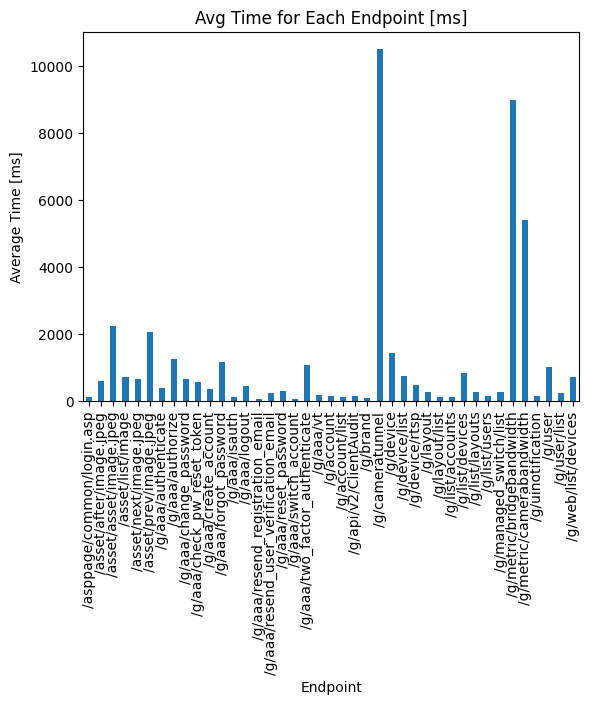

In [65]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Average Time [ms]')
plt.title('Avg Time for Each Endpoint [ms]')
plt.show()

## Median response time at each hour - all endpoints

In [73]:
from pytz import timezone

# Convert 'Start time' column to datetime data type
df['Start time'] = pd.to_datetime(df['Start time'])

# Convert the timezone of the datetime object from UTC to CST
df['Start Time CST'] = df['Start time'].dt.tz_localize('UTC')
df['Start Time CST'] = df['Start Time CST'].dt.tz_convert('US/Central')

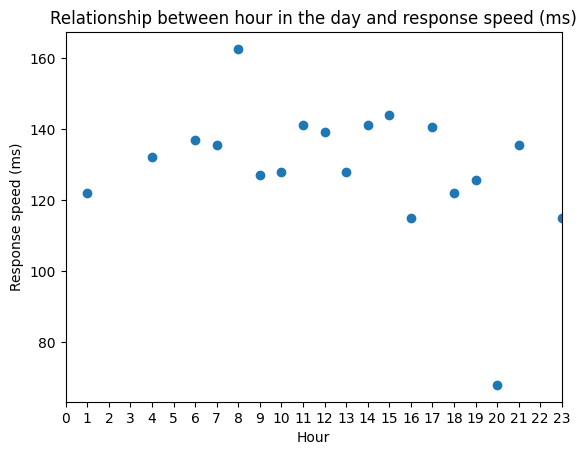

In [77]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour

#Calculate the mean duration for each hour
hourly_mean_duration = df.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()


## Speed throughout the day for endpoint - g/aaa/authenticate

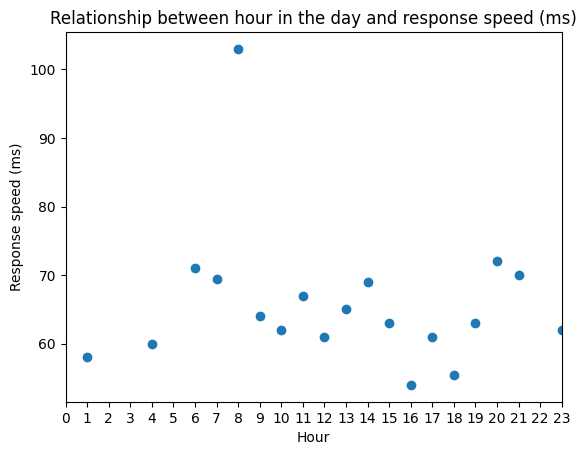

In [79]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour
df_auth = df[df['Endpoint'] == '/g/aaa/authenticate']

#Calculate the mean duration for each hour
hourly_mean_duration = df_auth.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()

# Median reponse time for PASS and FAIL

In [71]:
avg_time_by_result = df.groupby('Test Result')['Duration till body received[ms]'].median()
print(avg_time_by_result)

Test Result
FAIL    120.0
PASS    135.0
Name: Duration till body received[ms], dtype: float64


In [72]:
# Group the DataFrame by endpoint and Method, and calculate the median response time for each group
grouped = df.groupby(['Endpoint', 'Method', 'Test Result']).agg({'Duration till body received[ms]': 'median'}).reset_index()

# Filter the grouped DataFrame to include only PASS and FAIL results
grouped_pass = grouped[grouped['Test Result'] == 'PASS']
grouped_fail = grouped[grouped['Test Result'] == 'FAIL']

# Merge the two DataFrames
result = pd.merge(grouped_pass, grouped_fail, on=['Endpoint', 'Method'], suffixes=('_pass', '_fail'))

# Rename the column headers to be more concise
result = result.rename(columns={'Test Result_pass': 'Result', 'Test Result_fail': 'Result','Duration till body received[ms]_pass': 'Pass_median', 'Duration till body received[ms]_fail': 'Fail_median'})
print(result)

                     Endpoint  Method Result  Pass_median Result  Fail_median
0   /asppage/common/login.asp     GET   PASS        112.5   FAIL        111.0
1         /g/aaa/authenticate    POST   PASS         65.0   FAIL         67.0
2            /g/aaa/authorize    POST   PASS        702.0   FAIL        132.0
3      /g/aaa/change_password    POST   PASS        104.0   FAIL        100.5
4               /g/aaa/logout    POST   PASS         83.0   FAIL         75.0
5             /g/cameratunnel     PUT   PASS       3141.0   FAIL        636.0
6                   /g/device     GET   PASS        163.0   FAIL        645.0
7                   /g/device     PUT   PASS       1195.0   FAIL      61261.5
8             /g/list/devices     GET   PASS        313.0   FAIL        119.5
9                     /g/user  DELETE   PASS        139.0   FAIL         83.0
10                    /g/user    POST   PASS        189.0   FAIL        161.0
11                    /g/user     PUT   PASS        209.0   FAIL

# The response length by endpoint

In [66]:
grouped = df_no_fail.groupby('Endpoint')['Response Body Length'].mean()

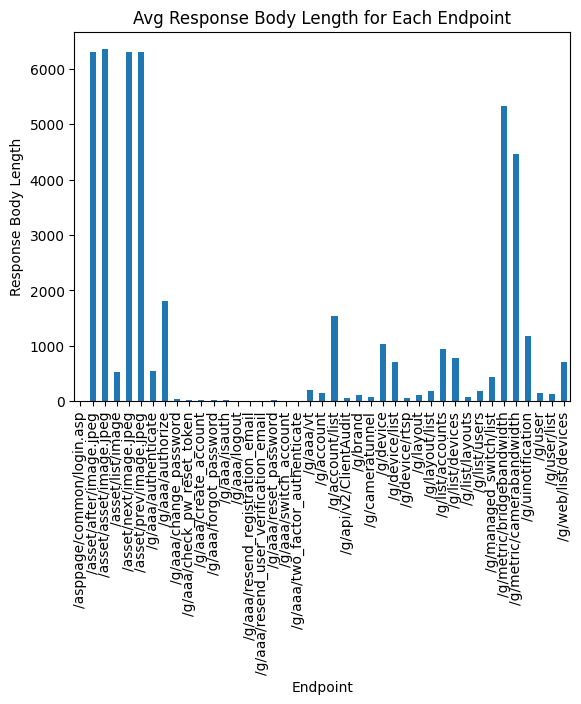

In [67]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Response Body Length')
plt.title('Avg Response Body Length for Each Endpoint')
plt.show()

# Does length of response payload and response speed correlate?

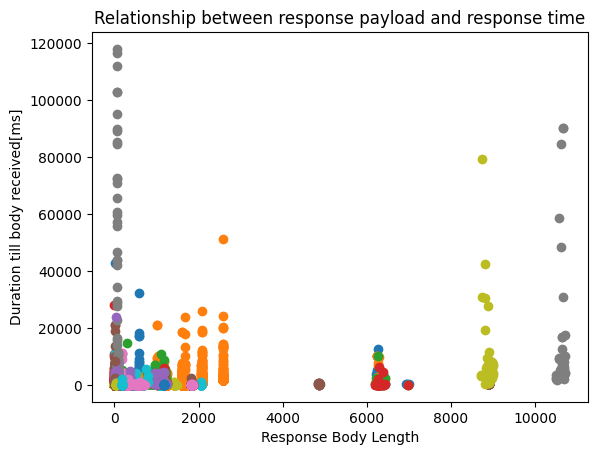

In [10]:
grouped = df_no_fail.groupby(['Endpoint', 'Response Body Length'])['Duration till body received[ms]'].median()

# create a scatter plot to represent the relationship between response payload and response time
fig, ax = plt.subplots()
for endpoint in df_no_fail['Endpoint'].unique():
    endpoint_df = df_no_fail[df_no_fail['Endpoint'] == endpoint]
    ax.scatter(endpoint_df['Response Body Length'], endpoint_df['Duration till body received[ms]'], label=endpoint)
ax.set_xlabel('Response Body Length')
ax.set_ylabel('Duration till body received[ms]')
ax.set_title('Relationship between response payload and response time')
#ax.legend()
plt.show()

In [11]:
length_time_df = df_no_fail[['Response Body Length', 'Duration till body received[ms]']]

corr = length_time_df.corr().iloc[0,1]

print('Correlation Coefficient: ', corr)

Correlation Coefficient:  0.13679069957132536
